In [1]:
!mkdir data
!mkdir uci_bow
!mkdir multiwoz_batches

!git clone https://github.com/shoaib6174/MultiWOZ-Clustering/

!pip install bigartm10
!pip install pyclustering

Cloning into 'MultiWOZ-Clustering'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 32 (delta 19), reused 32 (delta 19), pack-reused 0
Unpacking objects: 100% (32/32), done.
     |████████████████████████████████| 2.0 MB 5.2 MB/s 
     |████████████████████████████████| 2.6 MB 5.4 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395121 sha256=2a527c39c08d322e573ba763bf6499d282ec262f31d02c3b2665f896da3a22f9
  Stored in directory: /root/.cache/pip/wheels/ea/87/6b/1e0568b5ba9dc6518a25338bae90bd8392f35206bb90bb10f1
Successfully built pyclustering


In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

import nltk
import string 
import artm

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

from pyclustering.utils import read_sample;
from pyclustering.cluster.dbscan import dbscan
from pyclustering.cluster.optics import optics, ordering_analyser, ordering_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer


In [3]:
def extract_utterance(data):
    """
    Description: Returns a list of utterances from single json file
    Params: 
        data: json file of dialogue data
    """
    texts = []
    for item in data:
        for turn in item['turns']:

            text = turn['utterance']
            texts.append(text)
    return texts
def extract_texts(path):
    """
    Description: Returns a list of utterances extacted from folder of json file of dialogues

    Params:
      path: path of folder containing json file of dialogue data
    """   
    texts = []
    file_list = os.listdir(path)
    for file in file_list:
        with open(f'{path}/{file}') as f:
            data = json.load(f)
            texts += (extract_utterance(data))
    return texts
            


In [4]:
def clean(text):
  """
  Description: Returns cleaned text
  Params: 
    text: text to be cleaned
  """
  tokens = nltk.tokenize.word_tokenize(text)
  tokens = [w.lower() for w in tokens]
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  words = [word for word in stripped if word.isalpha()]
  words = [w for w in words if not w in stop_words]
  

  stemmed_words = [stemmer.stem(word) for word in words]
  sentence = " ".join(stemmed_words)
  return sentence

In [5]:
nltk.download("stopwords")
nltk.download('punkt')

stop_words = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Load and Clean Data

In [6]:
# extract utterances from json files 
path = 'MultiWOZ-Clustering/train'
texts = extract_texts(path)

# clean the utterances
cleaned_text = []
for text in texts:
  cleaned_text.append(clean(text))

#TF-IDF

In [7]:
tfidf = TfidfVectorizer()

response = tfidf.fit_transform(cleaned_text)

df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())

df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaint,aat,ab,abbey,abd,abil,abl,ablt,aboard,abotu,abou,abound,aboutdo,absent,absolut,abund,abvail,academ,accept,access,accid,accident,acclaim,accomad,accomid,accommod,accomod,accord,accorn,accual,accur,achitectur,acknowledg,acllasu,acom,acommod,acorn,acovvezm,acquir,acron,...,youi,youlik,your,yourselfy,youthank,youthat,youu,ype,ypou,ypu,yqdwlhdw,yqxgplli,ytamnaao,ytoiuy,ytou,yu,yuck,yugo,yummi,yup,yur,yzerkjxh,zealand,zellmali,zero,zerostar,zieexay,zip,zipcod,zizi,zizzi,zjxdbrkw,zkogbrmr,zmgywsso,zone,zoo,zsdflxsj,ztgxvbxu,ztvsjgbz,zxibgev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# UCI Bag of Words Format

In [8]:
D = len(df.index)
W = len(df.columns)
C = np.count_nonzero(df)
print(D, W, C)

with open('uci_bow/docword.multiwoz.txt', 'w') as docword:
  docword.write(f"{D}\n{W}\n{C}\n")
  for docID , row in df.iterrows():
    for wordID , val in enumerate(row):
      if val > 0:
        docword.write(f"{docID } {wordID+1 } {val}\n")


with open('uci_bow/vocab.multiwoz.txt', 'w') as vocab:
  for col in df.columns:
    vocab.write(f"{col}\n")

113552 4503 685983


# Topic Modeling

In [9]:
num_topics = 64
alpha = 0.01
beta = 0.001
cache_theta = True 
num_document_passes = 5


batch_vectorizer = artm.BatchVectorizer(data_path='/content/uci_bow', data_format='bow_uci',
                                        collection_name='multiwoz', target_folder='multiwoz_batches')

lda = artm.LDA(num_topics = num_topics, alpha=alpha, beta=beta, cache_theta=cache_theta,
               num_document_passes=num_document_passes, dictionary=batch_vectorizer.dictionary)

lda.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

topic_df = lda.get_theta()

topic_df = topic_df.T
topic_df

with open("topic_data.txt", 'w') as topic_data:
  for idx, row in topic_df.iterrows():
    for val in row:
      topic_data.write(f"{val} ")
    topic_data.write("\n")

In [10]:
def show_hist(clusters, title):
  """
  Description: Shows a histogram of count of items in each clusters, No oftotoal clusters and 
                total count of items in the clusters
  Params: 
    clusters: a list containing the lists of items of each clusters
    titile: Name of the algorithom
  """
  names = list(f"{i+1}" for i in range(len(clusters)) )
  values = list(len(c) for c in clusters)
  print(f"Total Cluster: {len(clusters)} \nTotal count of uttarance in Clusters:{sum(values)}")
  y_pos = np.arange(len(clusters))

  plt.figure(figsize=(20,10))
  plt.bar(y_pos, values, align='center', alpha=0.5)
  plt.xticks(y_pos, names)
  plt.ylabel('Count')
  plt.title(title)

  plt.show()

# Read Topic Data

In [11]:
data = read_sample("topic_data.txt")

# DBSCAN

Total Cluster: 555 
Total count of uttarance in Clusters:26386


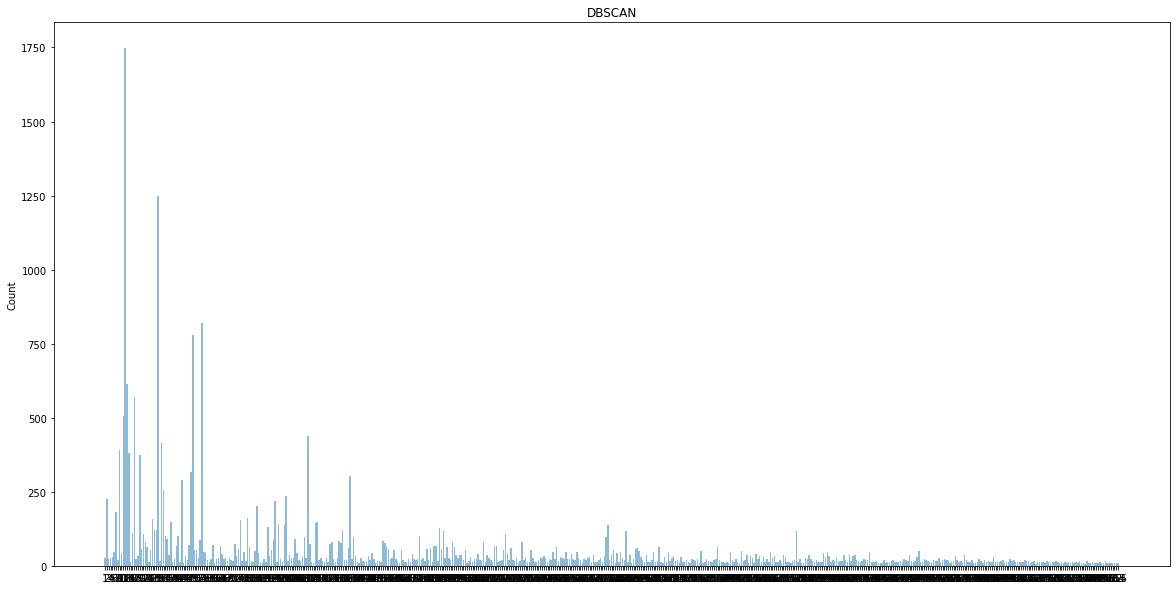

In [14]:
eps = .1
neighbors = 10

dbscan_instance = dbscan(data, eps, neighbors);
dbscan_instance.process();
clusters = dbscan_instance.get_clusters();

#histogram
show_hist(clusters, "DBSCAN")


# Optics

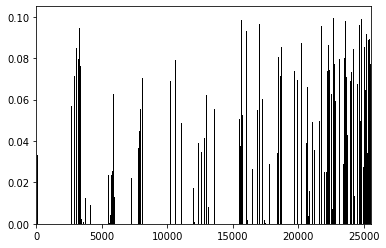

Total Cluster: 555 
Total count of uttarance in Clusters:26122


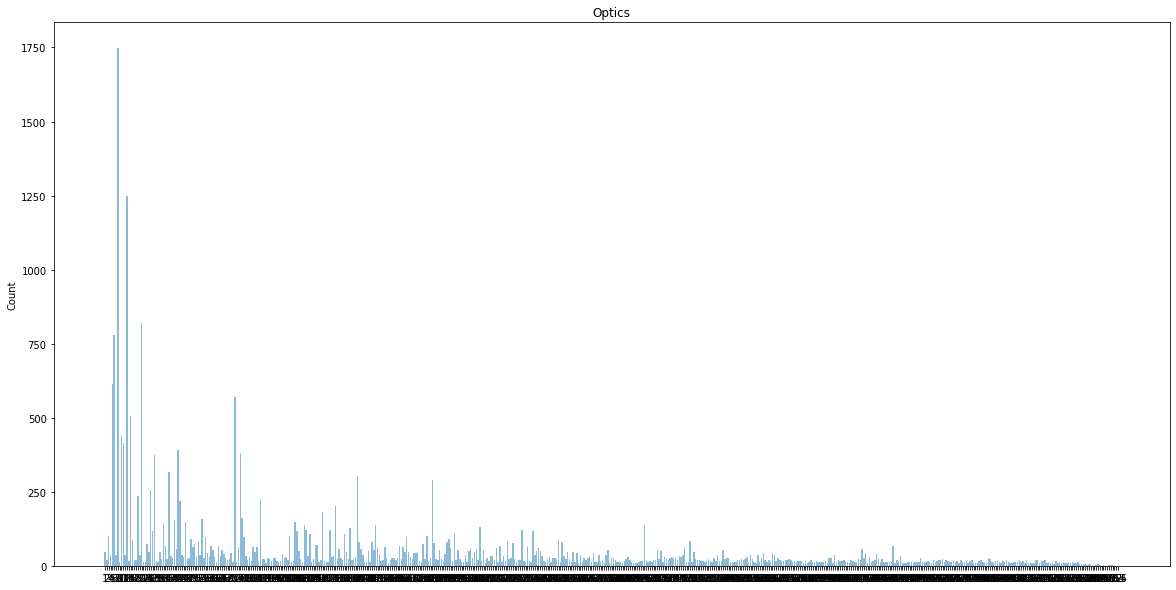

In [12]:
radius = .1
neighbors= 10
#amount_of_clusters = 10

optics_instance = optics(data, radius, neighbors)
optics_instance.process()
 
# Obtain results of clustering
clusters = optics_instance.get_clusters()
#noise = optics_instance.get_noise()
ordering = optics_instance.get_ordering()
 
# Visualize ordering diagram
analyser = ordering_analyser(ordering)
ordering_visualizer.show_ordering_diagram(analyser)
 

#histogram
show_hist(clusters, "Optics")


# XMEANS

Total WCE: 7497.7407187094295
Total Cluster: 100 
Total count of uttarance in Clusters:113417


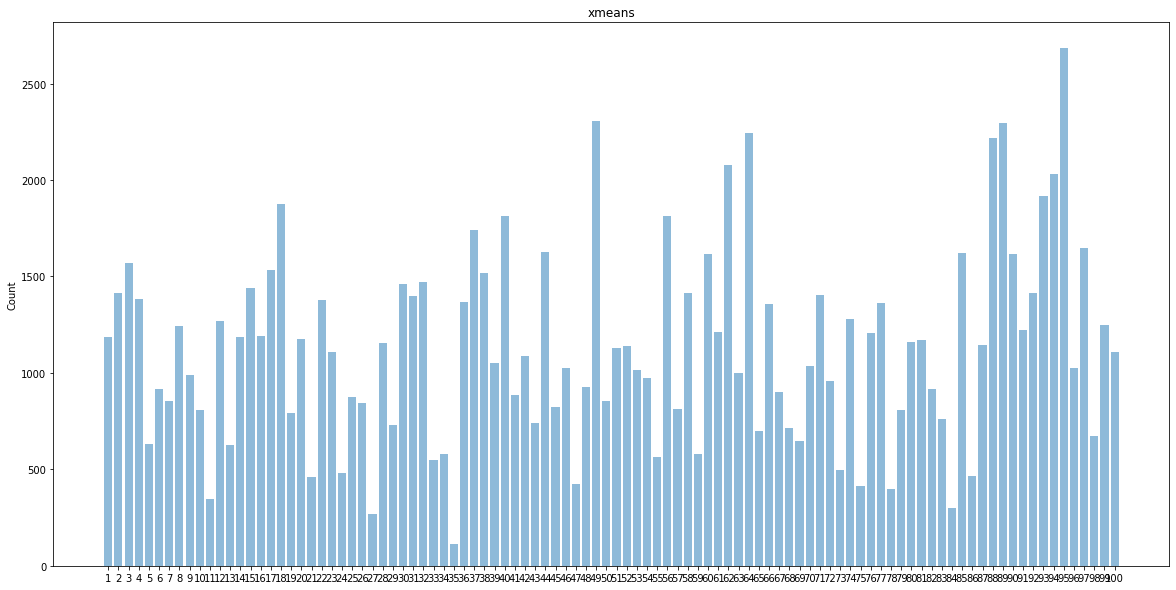

In [13]:

amount_initial_centers = 30
number_of_clusters = 100
initial_centers = kmeans_plusplus_initializer(data, amount_initial_centers).initialize()
 
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is number_of_clusters.
xmeans_instance = xmeans(data, initial_centers, number_of_clusters)
xmeans_instance.process()
 
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
 
# Print total sum of metric errors
print("Total WCE:", xmeans_instance.get_total_wce())
 
#histogram
show_hist(clusters, "xmeans")